# *This notebook contains the code for the Coursera Capstone IBM Data Science Certificate*

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score, classification_report
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

In [59]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_05e6e145e45a40a6868fc5018924ebc2 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_05e6e145e45a40a6868fc5018924ebc2.get_object(Bucket='courseracapstone-donotdelete-pr-ksauy74m0lfpxv',Key='Data-Collisions.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data = pd.read_csv(body)
df_data.head()


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [60]:
df_data.info()
# further research into the columns which have significant missing data 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 38 columns):
SEVERITYCODE      194673 non-null int64
X                 189339 non-null float64
Y                 189339 non-null float64
OBJECTID          194673 non-null int64
INCKEY            194673 non-null int64
COLDETKEY         194673 non-null int64
REPORTNO          194673 non-null object
STATUS            194673 non-null object
ADDRTYPE          192747 non-null object
INTKEY            65070 non-null float64
LOCATION          191996 non-null object
EXCEPTRSNCODE     84811 non-null object
EXCEPTRSNDESC     5638 non-null object
SEVERITYCODE.1    194673 non-null int64
SEVERITYDESC      194673 non-null object
COLLISIONTYPE     189769 non-null object
PERSONCOUNT       194673 non-null int64
PEDCOUNT          194673 non-null int64
PEDCYLCOUNT       194673 non-null int64
VEHCOUNT          194673 non-null int64
INCDATE           194673 non-null object
INCDTTM           194673 non-null obje

# Remove columns that are irrelevant

In [61]:
df_data['SPEEDING'].isnull().sum()/df_data.shape[0]
#95% of the rows in Speeding columns are NAN

0.9520580666039975

In [62]:
df_data = df_data.drop(['OBJECTID','INCKEY','LOCATION','COLDETKEY','REPORTNO','STATUS','INTKEY','EXCEPTRSNCODE',
              'EXCEPTRSNDESC','SEVERITYDESC','SDOT_COLCODE','SDOT_COLDESC','SDOTCOLNUM','ST_COLCODE',
              'ST_COLDESC','SEGLANEKEY','CROSSWALKKEY'],axis=1)


In [63]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 21 columns):
SEVERITYCODE      194673 non-null int64
X                 189339 non-null float64
Y                 189339 non-null float64
ADDRTYPE          192747 non-null object
SEVERITYCODE.1    194673 non-null int64
COLLISIONTYPE     189769 non-null object
PERSONCOUNT       194673 non-null int64
PEDCOUNT          194673 non-null int64
PEDCYLCOUNT       194673 non-null int64
VEHCOUNT          194673 non-null int64
INCDATE           194673 non-null object
INCDTTM           194673 non-null object
JUNCTIONTYPE      188344 non-null object
INATTENTIONIND    29805 non-null object
UNDERINFL         189789 non-null object
WEATHER           189592 non-null object
ROADCOND          189661 non-null object
LIGHTCOND         189503 non-null object
PEDROWNOTGRNT     4667 non-null object
SPEEDING          9333 non-null object
HITPARKEDCAR      194673 non-null object
dtypes: float64(2), int64(6), object(

In [64]:
# remove columns with large amount of missing data
df_data = df_data.drop(["INATTENTIONIND","PEDROWNOTGRNT"],axis=1)


In [65]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194673 entries, 0 to 194672
Data columns (total 19 columns):
SEVERITYCODE      194673 non-null int64
X                 189339 non-null float64
Y                 189339 non-null float64
ADDRTYPE          192747 non-null object
SEVERITYCODE.1    194673 non-null int64
COLLISIONTYPE     189769 non-null object
PERSONCOUNT       194673 non-null int64
PEDCOUNT          194673 non-null int64
PEDCYLCOUNT       194673 non-null int64
VEHCOUNT          194673 non-null int64
INCDATE           194673 non-null object
INCDTTM           194673 non-null object
JUNCTIONTYPE      188344 non-null object
UNDERINFL         189789 non-null object
WEATHER           189592 non-null object
ROADCOND          189661 non-null object
LIGHTCOND         189503 non-null object
SPEEDING          9333 non-null object
HITPARKEDCAR      194673 non-null object
dtypes: float64(2), int64(6), object(11)
memory usage: 28.2+ MB


# Check to see if there is a pattern of more accidents depending on the day of the week

In [67]:
analysis = df_data.copy()
analysis['day_of_week'] = pd.DatetimeIndex(analysis['INCDATE']).weekday_name
analysis['day_of_week'].value_counts(normalize=True)
# plt.figure(figsize=(20,10))
# sns.countplot(x='day_of_week', data = df_data)
# plt.title('Accident occurances by day', fontsize=18)
# sns.set(style="darkgrid")


Friday       0.166089
Thursday     0.150632
Wednesday    0.147827
Tuesday      0.146687
Saturday     0.140692
Monday       0.135294
Sunday       0.112779
Name: day_of_week, dtype: float64

In [72]:
df_data['SPEEDING'] = df_data['SPEEDING'].apply(lambda x: 1 if x=='Y' else 0)
df_data['SPEEDING'].isna().sum()

0

In [73]:
df_data.groupby('ROADCOND')['SEVERITYCODE'].mean()

ROADCOND
Dry               1.321773
Ice               1.225806
Oil               1.375000
Other             1.325758
Sand/Mud/Dirt     1.306667
Snow/Slush        1.166335
Standing Water    1.260870
Unknown           1.049675
Wet               1.331866
Name: SEVERITYCODE, dtype: float64

In [75]:
df_data['SEVERITYCODE'].value_counts(normalize=True)

1    0.701099
2    0.298901
Name: SEVERITYCODE, dtype: float64

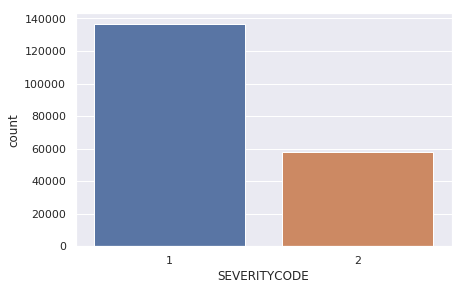

In [99]:
sns.set(style="darkgrid")
sns.countplot(x='SEVERITYCODE', data = df_data)

# Check data for monthly and yearly patterns

In [49]:
df_data['month'] = pd.DatetimeIndex(df_data['INCDATE']).month
df_data['year'] = pd.DatetimeIndex(df_data['INCDATE']).year
df_data['month'].head()

0     3
1    12
2    11
3     3
4     1
Name: month, dtype: int64

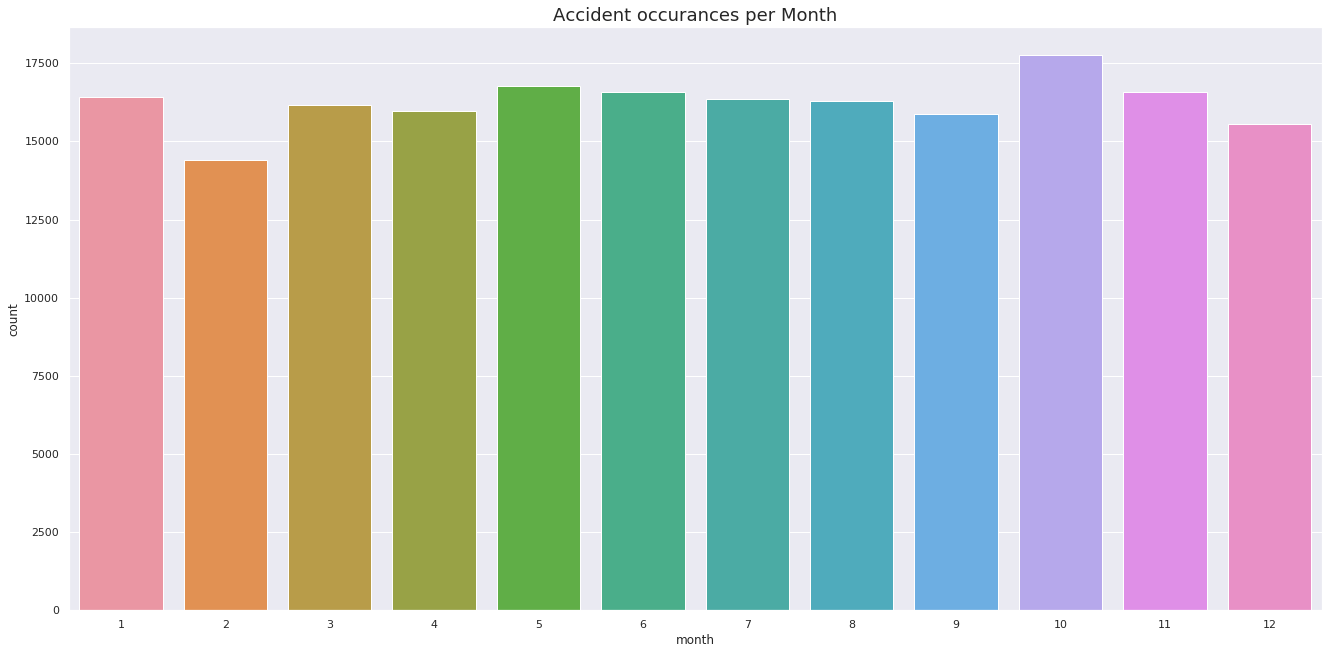

In [107]:
plt.figure(figsize=(20,10))
sns.countplot(x='month', data = df_data)
plt.title('Accident occurances per Month', fontsize=18)
sns.set(style="darkgrid")


Text(0.5, 1.0, 'Accident occurances per Year')

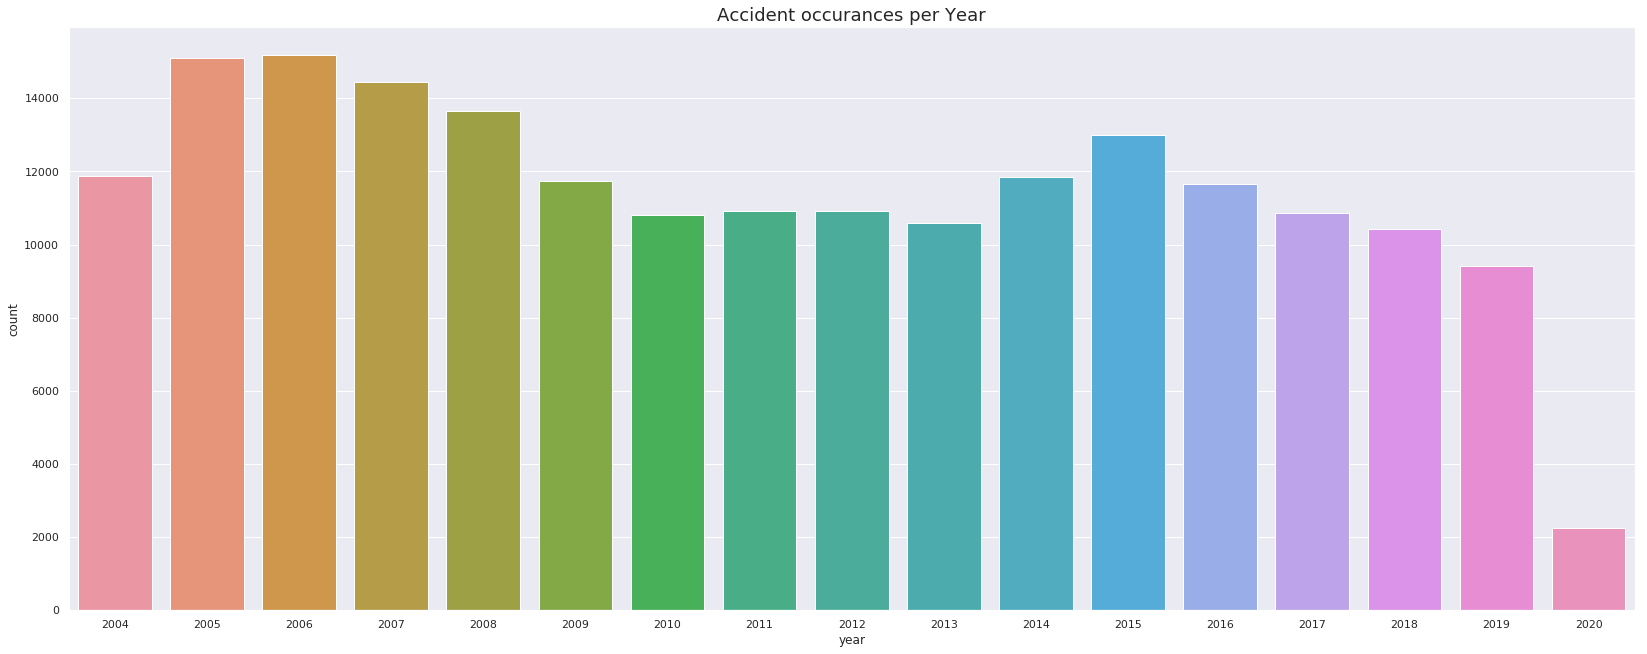

In [103]:
plt.figure(figsize=(25,10))
monthly_accident = sns.countplot(x='year', data = df_data)
plt.title('Accident occurances per Year', fontsize=18)

# Check and clean the Under the Influence data - change N to 0 and y to 1

In [120]:
df_data['UNDERINFL'].replace("N",0, inplace=True)
df_data['UNDERINFL'].replace('Y',1, inplace=True)
df_data['UNDERINFL'].replace('1',1, inplace=True)
df_data['UNDERINFL'].replace('0',0, inplace=True)
df_data['UNDERINFL'].value_counts()


0.0    180668
1.0      9121
Name: UNDERINFL, dtype: int64

In [129]:
df_data['INCDATE'] = pd.to_datetime(df_data['INCDATE'])

# Delete unnecessary columns

In [139]:
# df_data['HITPARKEDCAR'] = df_data['HITPARKEDCAR'].replace({'N': 0, 'Y': 1})
df_data['HITPARKEDCAR'].value_counts(normalize=True)

0    0.962933
1    0.037067
Name: HITPARKEDCAR, dtype: float64

In [8]:
features = df_data[[ 'INCDATE', 'ADDRTYPE', 'HITPARKEDCAR', 'LIGHTCOND', 'ROADCOND', 'WEATHER', 'UNDERINFL', 'SEVERITYCODE']]
print(features.shape)
features.head()

(194673, 8)


,INCDATE,ADDRTYPE,HITPARKEDCAR,LIGHTCOND,ROADCOND,WEATHER,UNDERINFL,SEVERITYCODE
0,2013/03/27 00:00:00+00,Intersection,N,Daylight,Wet,Overcast,N,2
1,2006/12/20 00:00:00+00,Block,N,Dark - Street Lights On,Wet,Raining,0,1
2,2004/11/18 00:00:00+00,Block,N,Daylight,Dry,Overcast,0,1
3,2013/03/29 00:00:00+00,Block,N,Daylight,Dry,Clear,N,1
4,2004/01/28 00:00:00+00,Intersection,N,Daylight,Wet,Raining,0,2


In [19]:
features['SEVERITYCODE'].value_counts()

1    136485
2     58188
Name: SEVERITYCODE, dtype: int64